# Results from WandB


## Imports

In [1]:
from community.utils.plotting import set_style
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
from itertools import product
import ipywidgets as widgets
import os

In [2]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh
from community.utils.plotting import legend_without_duplicate_labels
from community.data.datasets.mnist import estimate_covariance

In [3]:
%load_ext autoreload
%autoreload 2

## Load Results

In [27]:
def load_pd_file(sweep_id=None, run_id=None):
    assert not (
        sweep_id is None and run_id is None
    ), "Please provide either a sweep_id or a run_id"
    final_path = f"{sweep_id}/" if sweep_id else f"runs/{run_id}/"

    try:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{final_path}/metric_table"
        )
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{final_path}/metric_table_safe"
        )

    p = total_data["sparsity"]
    total_data["q_metric"] = 0.5 * (1 - p) / (1 + p)

    try:
        total_data["n_conns"] = (
            (total_data["n_hidden"] ** 2 * total_data["sparsity"]).round().astype(int)
        )
        total_data["n_conns_sqrt"] = np.sqrt(total_data["n_conns"])
    except KeyError:
        total_data["n_conns"] = (
            (25 ** 2 * total_data["sparsity"]).round().astype(int)
        )
        total_data["n_conns_sqrt"] = np.sqrt(total_data["n_conns"])

    return total_data

In [28]:
def single_filter(data, key, value):
    if key[0] == "!":
        if value is None:
            return ~data[key[1:]].isnull()
        else:
            return data[key[1:]] != value
    else:
        if value is None:
            return data[key].isnull()
        else:
            return data[key] == value


def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if key in data.columns or (key[0] == "!" and key[1:] in data.columns):
            if isinstance(value, list):
                filter = np.sum(
                    [single_filter(data, key, v) for v in value], axis=0
                ).astype(bool)
            else:
                filter = single_filter(data, key, value)

        data = data[filter]

    return data, filter


def get_values(data, x="n_hidden", y="sparsity", value="retraining_global_diff"):
    return data[[x, y, value]].values.T


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]

In [29]:
# run_id = "nrfi6oxg"
run_id = None

sweep_id = "hqx9dkom"  # metric (fig 1)
sweep_id = "h4213kcu"  # heatmaps (fig 2)
sweep_id = "sg3i8mhb"  # dynamics (fig 3)

total_data = load_pd_file(run_id=run_id, sweep_id=sweep_id)


In [30]:
total_data["n_classes"] = total_data["data_type"].apply(
    lambda d: {"double_digits": 10, "double_letters": 16}[d]
)

try:
    covariances = {}
    for n in total_data["n_classes"].unique():
        for c in total_data["cov_ratio"].unique():
            covariances[n, c] = estimate_covariance(c, int(n))
    total_data["covariance"] = [
        covariances[n, c] for c, n in total_data[["cov_ratio", "n_classes"]].values
    ]
    total_data["covariance"] = total_data["covariance"].abs()
    total_data["covariance"].min()
except KeyError:
    pass

In [31]:
# Normalize metric values

total_data_base = filter_data(total_data, {"!metric_name": "base_correlations"})[0]

# filter_params = [{'metric_name' : 'retraining', 'ag' : i} for i in range(2)]
# f_datas = [filter_data(total_data, fp) for fp in filter_params]
total_data_base["base_metric_value"] = total_data_base["metric_value"].copy()

total_data_base.loc[
    filter_data(total_data_base, {"metric_name": "correlations"})[1],
    "base_metric_value",
] = filter_data(total_data, {"metric_name": "base_correlations"})[0][
    "metric_value"
].array

total_data_base.loc[
    filter_data(total_data_base, {"!metric_name": "correlations"})[1],
    "base_metric_value",
] = 0.1

total_data_base["normed_metric_value"] = (
    np.clip(
        total_data_base["metric_value"] - total_data_base["base_metric_value"], 0, 1
    )
) / (1 - total_data_base["base_metric_value"])

In [32]:

# Target specific data
target_datas = [
    filter_data(total_data_base, {"!ag": "all", "target": i})[0] for i in range(2)
]

if True : 
        
    # Compute ablations ratios
    for data in target_datas:
        data.loc[filter_data(data, {"metric_name": "ablations"})[1], "metric_value"] = (
            1
            - filter_data(data, {"metric_name": "ablations"})[0]["metric_value"].array
            / filter_data(total_data_base, {"metric_name": "retraining", "ag": "all"})[0][
                "metric_value"
            ].array
        )
    

In [33]:
# Create agent specific data
ag_data = target_datas[0].copy()
[
    ag_data.pop(k)
    for k in ["target", "metric_value", "normed_metric_value", "base_metric_value"]
]
ag_data["metric_value"] = (
    target_datas[0]["normed_metric_value"].array
    - target_datas[1]["normed_metric_value"].array
) / (
    target_datas[0]["normed_metric_value"].array
    + target_datas[1]["normed_metric_value"].array
)
ag_datas = [filter_data(ag_data, {"ag": i})[0] for i in range(2)]

# Create model specific data
model_data = ag_datas[0].copy()
[model_data.pop(k) for k in ["ag", "metric_value"]]
model_data["metric_value"] = (
    np.abs(ag_datas[0]["metric_value"].array - ag_datas[1]["metric_value"].array) / 2
)

for c in model_data.columns:
    model_data.loc[model_data[c].isnull(), c] = "None"

In [34]:
metric_names = ["retraining", "ablations", "correlations"]
metrics_values = {m : filter_data(model_data, {"metric_name": m})[0]["metric_value"] for m in metric_names}


In [12]:
raise StopIteration

StopIteration: 

## Fig 1

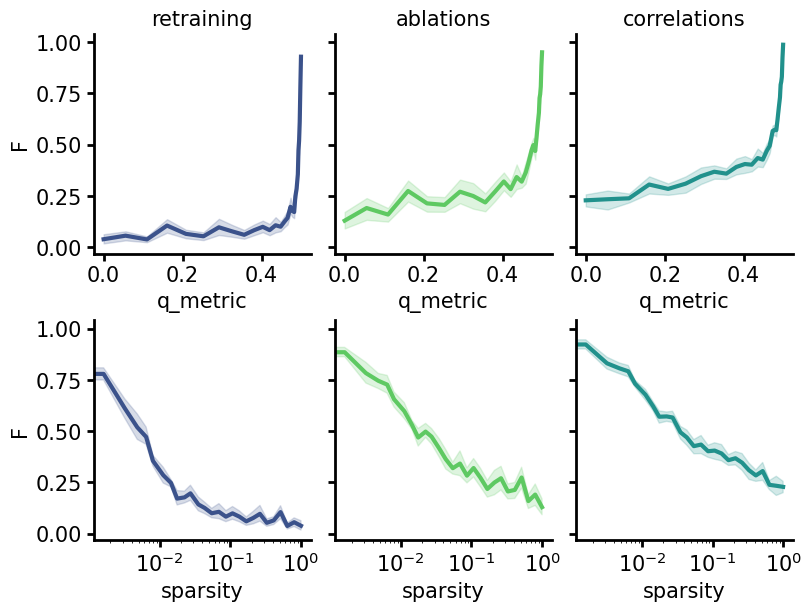

In [ ]:
set_style()
palette = sns.palettes.color_palette("viridis", len(metric_names))
colors = [palette[i] for i in [0, 2, 1]]
fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharey=True, constrained_layout=True)

for i, (x_axs, x) in enumerate(zip(axs, ["sparsity", "q_metric"][::-1])):
    for ax, metric_name, c in zip(x_axs, metric_names, colors):
        filter_params = {
            "metric_name": metric_name,
            "step": 1,
            "noise_ratio": "None",
            "n_bot": "None",
        }
        f_data = filter_data(model_data, filter_params)[0]
        sns.lineplot(
            data=f_data, x=x, y="metric_value", color=c, ax=ax
        )  # , style="noise_ratio", hue='n_bot')
        ax.set_ylabel("F")
        ax.set_xlabel(x)
        if x == "sparsity":
            ax.set_xscale("log")
        if i == 0:
            ax.set_title(metric_name)

In [ ]:
metrics = np.stack([filter_data(model_data, {"metric_name": m})[0]["metric_value"] for m in metric_names]).astype(float)

In [ ]:
metrics

array([[0.92302749, 0.92538811, 0.93150843, ..., 0.07131845, 0.9095629 ,
        0.20501694],
       [0.95857022, 0.94998321, 0.97361935, ..., 0.17999408, 0.97759674,
        0.3829117 ],
       [0.99870761, 0.99537097, 0.9917142 , ..., 0.16266268, 0.99372774,
        0.27699836]])

In [ ]:
np.corrcoef(metrics)

array([[1.        , 0.97224316, 0.97220932],
       [0.97224316, 1.        , 0.97729396],
       [0.97220932, 0.97729396, 1.        ]])

In [ ]:
# fig.savefig('../../results/imgs/norm_metrics.svg', dpi=300)

## Fig 2

In [ ]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh

In [ ]:
def get_values(data, x="n_hidden", y="sparsity", value="retraining"):
    return data[[x, y, value]].values.T

Plotting Heatmaps:   0%|          | 0/6 [00:00<?, ?it/s]

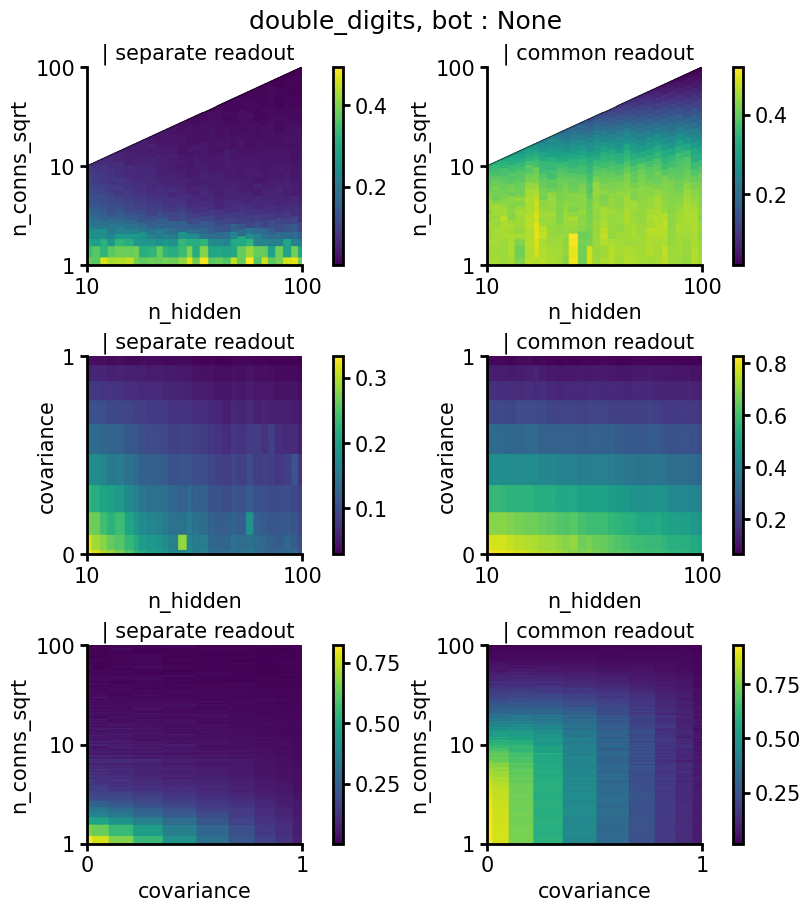

In [ ]:
set_style()

metric = "metric_value"

x_label = "n_hidden"
y_label = "n_conns_sqrt"

metric_names = ["retraining", "ablations", "correlations"][:1]
n_bots = ["None", 5][:1]
datas = ["double_digits", "double_letters"][:1]
common_readouts = [False, True]

x_labels = ["n_hidden", "n_hidden", "covariance"]
y_labels = ["n_conns_sqrt", "covariance", "n_conns_sqrt"]
log_scales = {"n_hidden": True, "n_conns_sqrt": True, "covariance": False}

ticks = {
    "n_hidden": [10, 100],
    "n_conns_sqrt": [1, 10, 100],
    "covariance": [total_data["covariance"].min(), total_data["covariance"].max()],
}
ticks_labels = {
    "n_hidden": [10, 100],
    "n_conns_sqrt": [1, 10, 100],
    "covariance": [0, 1],
}

pbar = tqdm(
    total=len(datas)
    * len(n_bots)
    * len(metric_names)
    * len(x_labels)
    * len(common_readouts),
    desc="Plotting Heatmaps: ",
)

fig = plt.figure(
    figsize=(
        4 * len(metric_names) * len(n_bots) * len(common_readouts),
        3 * len(x_labels) * len(datas),
    ),
    constrained_layout=True,
)

subfigs = fig.subfigures(len(datas), len(n_bots))
if len(datas) == 1:
    subfigs = np.array([subfigs])
if len(n_bots) == 1:
    subfigs = np.array([subfigs])

for (data_type, n_bot), subfig in zip(product(datas[:], n_bots), subfigs.flatten()):
    subfig.suptitle(f"{data_type}, bot : {n_bot}")
    axs = subfig.subplots(len(x_labels), len(metric_names) * len(common_readouts))
    # fig, axs = plt.subplots(2, 3, figsize=(5*3, 5*2), constrained_layout=True)

    for (x_label, y_label), axs_b in zip(zip(x_labels, y_labels), axs):
        for (metric_name, common_readout), ax in zip(
            product(metric_names[:], common_readouts), axs_b
        ):
            ax.set_title(f'{metric_name if len(metric_names) > 1 else ""} | {"common" * common_readout + "separate"* (1 - common_readout)} readout')
            heatmap_data = filter_data(
                model_data,
                {
                    "step": 1,
                    "common_input": False,
                    "common_readout": common_readout,
                    "n_bot": n_bot,
                    "data_type": data_type,
                    "metric_name": metric_name,
                    "!metric_value": "None",
                },
            )[0]
            heatmap_data = heatmap_data[heatmap_data["sparsity"] > 0]

            values = get_values(
                heatmap_data.groupby([x_label, y_label], as_index=False)[
                    [x_label, y_label, metric]
                ].mean(),
                x_label,
                y_label,
                metric,
            )

            (
                (X, Y),
                (X_mesh, Y_mesh),
                Z,
                (fig, ax),
                cbar,
            ) = compute_and_plot_colormesh(
                values,
                (fig, ax),
                log_scale=[log_scales[x_label], log_scales[y_label]],
                resolution=300,
                method="nearest",
                exclude_sup=(x_label == "n_hidden" and y_label == "n_conns_sqrt"),
                minmax=None,
                imshow=False,
                # random=True
            )
            pbar.update(1)

            # ax.xaxis.set_tick_params(labelbottom=False)
            # ax.yaxis.set_tick_params(labelleft=False)
            ax.minorticks_off()

            ax.set_xticks(ticks[x_label])
            ax.set_yticks(ticks[y_label])
            ax.set_xticklabels(ticks_labels[x_label])
            ax.set_yticklabels(ticks_labels[y_label])

            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

    # raise StopIteration

# ax.set_ylim(1e-1, 1e2)

## Fig 3

In [74]:
dynamic_data = ag_data.copy()

for c in dynamic_data.columns:
    dynamic_data.loc[dynamic_data[c].isnull(), c] = "None"

dynamic_data.loc[filter_data(dynamic_data, {'comms_start' : 'None'})[1], 'comms_start'] = 1.0
dynamic_data['comms_start'] = dynamic_data['comms_start'].astype(float)

dynamic_data.loc[filter_data(dynamic_data, {'noise_ratio' : 'None'})[1], 'noise_ratio'] = 0.



<AxesSubplot: xlabel='step', ylabel='metric_value'>

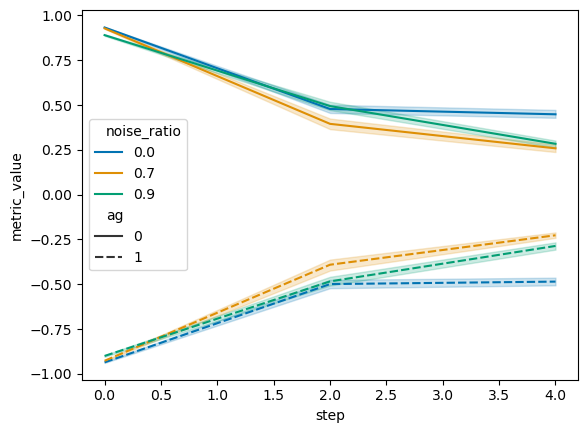

In [75]:
spec_data_ = filter_data(
        dynamic_data,
        {
            "n_bot": "None",
            "random_start": False,
            "metric_name": "retraining",
            "comms_start": 1,
            "n_conns" : [400, 500, 625]
        },
    )[0]

sns.lineplot(data=spec_data_, x='step', y='metric_value', hue='noise_ratio', style='ag', palette='colorblind')

In [88]:
spec_data_ = filter_data(
        dynamic_data,
        {
            "n_bot": "None",
            "random_start": False,
            "metric_name" : 'retraining'
        })[0]


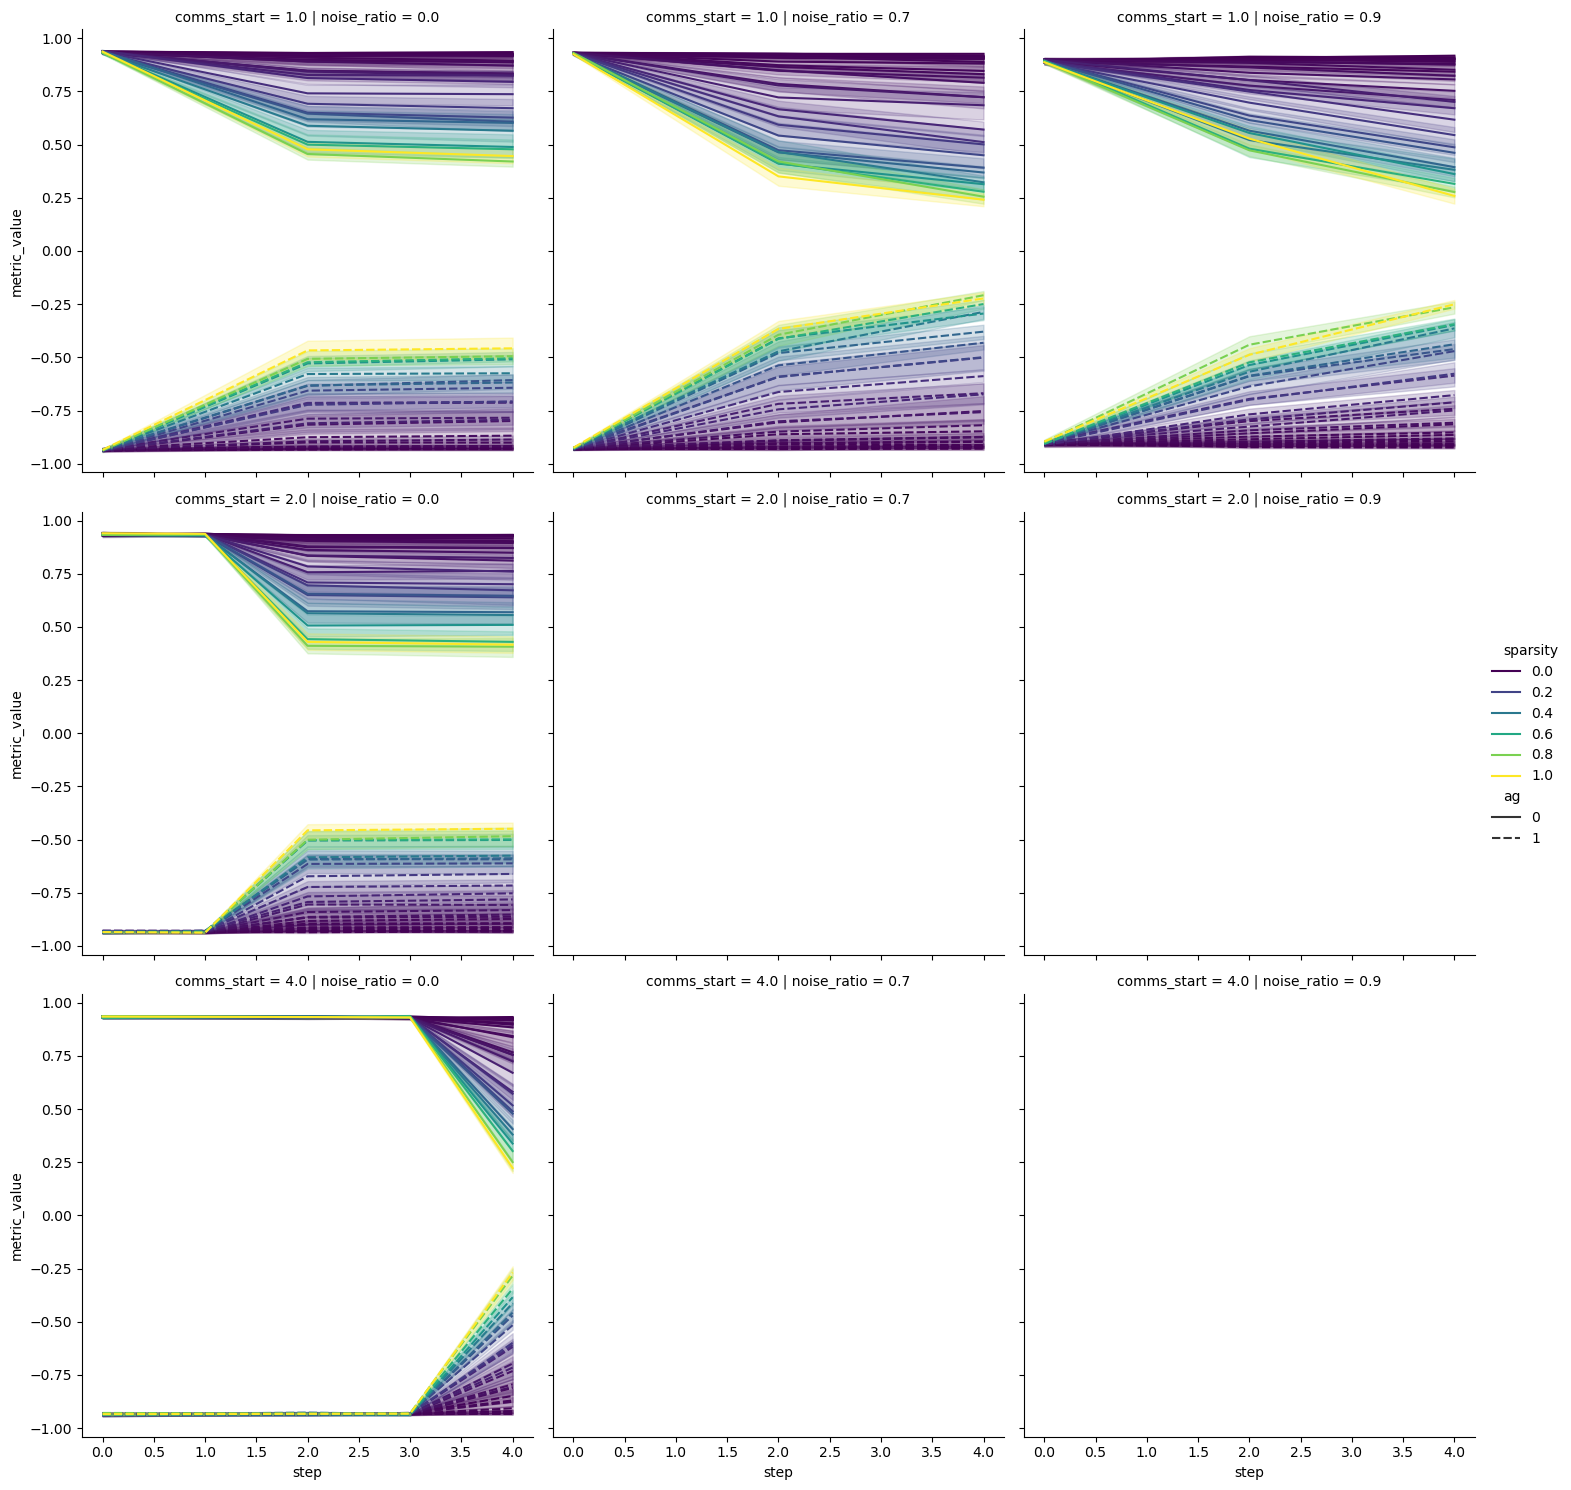

In [90]:
sns.relplot(
    data=spec_data_,
    x="step",
    y="metric_value",
    hue="sparsity",
    col="noise_ratio",
    row="comms_start",
    style="ag",
    kind="line",
    palette='viridis',
)

Plotting Dynamics:   0%|          | 0/6 [00:00<?, ?it/s]

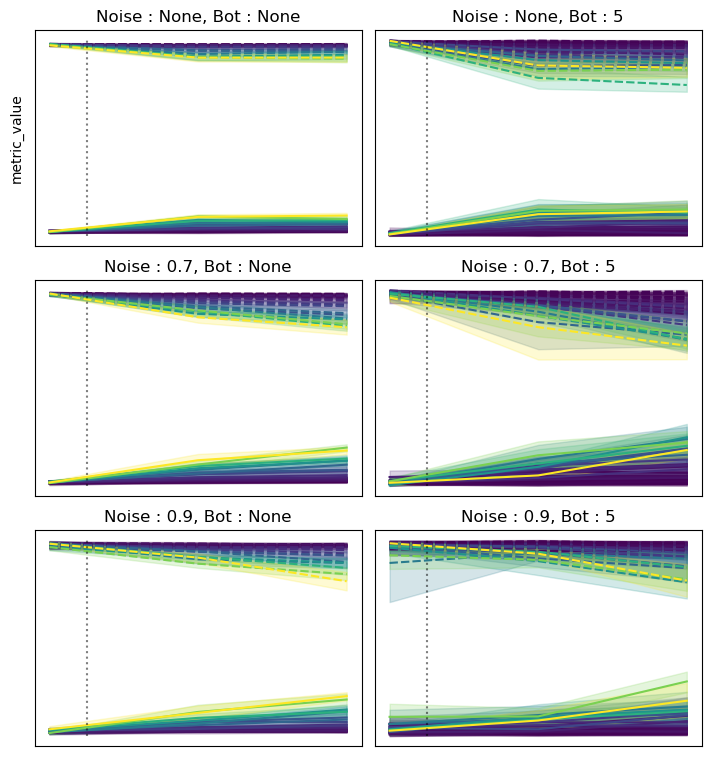

In [67]:
fig, axs = plt.subplots(
    3, 2, figsize=(3.5 * 2, 2.5 * 3), constrained_layout=True, sharex=True, sharey=True
)

spec_data_ = filter_data(
    dynamic_data,
    {"random_start": False, "metric_name": "ablations", "comms_start": 1},
)[0]

noise_ratios = spec_data_["noise_ratio"].unique()
n_bots = spec_data_["n_bot"].unique()
pbar = tqdm(total=len(noise_ratios) * len(n_bots), desc="Plotting Dynamics: ")
for ax, (noise_ratio, n_bot) in zip(axs.flatten(), product(noise_ratios, n_bots)):
    spec_data = filter_data(spec_data_, {"noise_ratio": noise_ratio, "n_bot": n_bot})[0]
    if not 0 in spec_data.shape:
        sns.lineplot(
            data=spec_data,
            x="step",
            y="metric_value",
            hue="sparsity",
            style="ag",
            palette="viridis",
            ax=ax,
            legend=False,
        )
        # ticks = ax.get_yticks()[0], ax.get_yticks()[-1]
        ax.vlines(
            1 - 0.5,
            -1,
            1,
            linestyles="dotted",
            colors="black",
            alpha=0.5,
        )
        ax.set_title(f"Noise : {noise_ratio}, Bot : {n_bot}")
        pbar.update(1)

        ax.set_yticks([])
        ax.set_xticks([])

Plotting Dynamics:   0%|          | 0/6 [00:00<?, ?it/s]

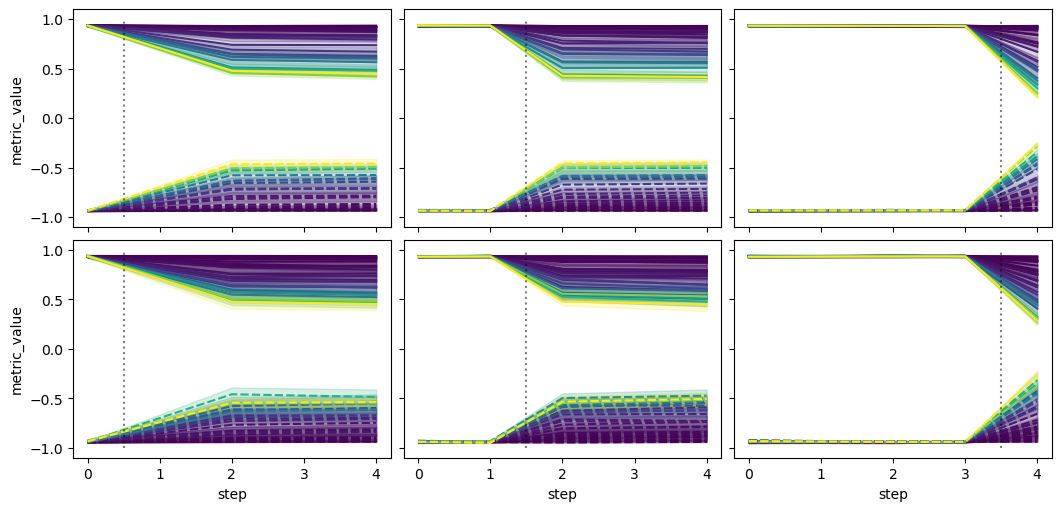

In [71]:
fig, axs = plt.subplots(
    2, 3, figsize=(3.5 * 3, 2.5 * 2), constrained_layout=True, sharex=True, sharey=True
)

spec_data_ = filter_data(
    dynamic_data,
    {"random_start": False, "metric_name": "retraining", "noise_ratio": "None"},
)[0]

comms_start = spec_data_["comms_start"].unique()
n_bots = spec_data_["n_bot"].unique()
pbar = tqdm(total=len(comms_start) * len(n_bots), desc="Plotting Dynamics: ")

for ax, (n_bot, c_start) in zip(axs.flatten(), product(n_bots, comms_start)):
    spec_data = filter_data(spec_data_, {"comms_start": c_start, "n_bot": n_bot})[0]
    if not 0 in spec_data.shape:
        sns.lineplot(
            data=spec_data,
            x="step",
            y="metric_value",
            hue="sparsity",
            style="ag",
            palette="viridis",
            ax=ax,
            legend=False,
        )
        # ticks = ax.get_yticks()[0], ax.get_yticks()[-1]
        ax.vlines(
            c_start - 0.5,
            -1,
            1,
            linestyles="dotted",
            colors="black",
            alpha=0.5,
        )
        # ax.set_title(f"Start : {c_start}, Bot : {n_bot}")
        pbar.update(1)

        # ax.set_yticks([])
        # ax.set_xticks([])

In [ ]:
def plot_spec_dynamics(
    varying_params,
    figax=None,
):
    c_data = filter_data(
        model_data,
        varying_params,
    )
    # return c_data
    if 0 not in c_data.shape:
        uniques = sorted(c_data["n_hidden"].unique().tolist())

        c_data = c_data[c_data["sparsity"] != 0]
        steps = c_data["step_str"].unique().tolist()
        try:
            steps.remove("")
        except ValueError:
            pass

        agents = ["0", "1", "all"]
        mul = [1, 1, 1]
        agents = [agents[0]] * len(steps) + [agents[-1]] + [agents[1]] * len(steps)
        mul = [mul[0]] * len(steps) + [mul[-1]] + [mul[1]] * len(steps)
        all_steps = steps + [steps[-1]] + steps[::-1]

        ts = np.arange(len(steps))
        ts = np.concatenate((ts, np.array([-1]), np.flip(ts)))
        ags = np.concatenate(
            (np.zeros(len(steps)), np.array([-1]), np.ones(len(steps)))
        ).astype(int)
        plot_data = {
            k: [] for k in ["x", "ag", "step", "metric", "sparsity", "n_conns"]
        }

        for x, (step, ag) in enumerate(zip(all_steps, agents)):
            metric = (
                c_data[c_data["step_str"] == step][f"retraining_{ag}_local_diff"]
            ) * mul[x]
            plot_data["x"].append(np.full_like(metric, x, dtype=int))
            plot_data["step"].append(np.full_like(metric, step, dtype=object))
            plot_data["ag"].append(np.full_like(metric, ag, dtype=object))
            plot_data["metric"].append(metric)
            plot_data["sparsity"].append(c_data[c_data["step_str"] == step]["sparsity"])
            plot_data["n_conns"].append(c_data[c_data["step_str"] == step]["n_conns"])

        plot_data = pd.DataFrame.from_dict(
            {k: np.concatenate(v) for k, v in plot_data.items()}
        )
        local_diffs = [
            c_data[c_data["step_str"] == s][f"retraining_{ag}_local_diff"]
            for s, ag in zip(steps, ags)
        ]

        if figax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
        else:
            fig, ax = figax

        sns.lineplot(
            plot_data,
            x="x",
            y="metric",
            hue="sparsity",
            palette="viridis",
            ax=ax,
            legend=False,
        )
        x = plot_data["x"].unique()

        steps_label = steps
        # steps_label = [f"t = {t}" for t in range(3)]
        x_labels = [f"{steps_label[t]}" for t in ts]
        x_labels[len(steps)] = "R"
        ax.set_xticks(x)
        ax.set_xticklabels(labels=x_labels)
        ax.set_xticklabels(labels=["" for _ in x_labels])
        # ax.set_ylim(-1, 1)
        ax.set_ylabel("Specialization")
        # ax.set_yticks([plot_data["metric"].min(), 0,  plot_data["metric"].max()])#, ["Full (1)", "None", "Full (0)"])
        ticks = ax.get_yticks()[0], ax.get_yticks()[-1]
        # ax.set_yticks([ax.get_yticks()[0], 0, ax.get_yticks()[-1]])

        ax.hlines(0, x[0], x[-1], linestyles="--", colors="black", alpha=0.1)
        ax.vlines(x, ticks[0], ticks[1], linestyles="--", colors="black", alpha=0.1)
        ax.fill_betweenx([ticks[0], ticks[1]], 0, len(steps) - 1, alpha=0.5, label="M0")
        ax.fill_betweenx(
            [ticks[0], ticks[-1]], len(steps) + 1, x[-1], alpha=0.5, label="M1"
        )
        ax.set_xlabel("")
        ax.legend()

        ax.set_yticks([ticks[0], 0, ticks[-1]])
        ax.set_yticks([])

        sm = plt.cm.ScalarMappable(cmap="viridis")
        sm.set_array([])
        cb = fig.colorbar(sm, orientation="vertical", ax=ax)
        cb.set_label("p", fontsize="small")
        # cb.set_ticks([0, 1], labels=["0", "Full"])

        return c_data, cb, ticks, x
    else:
        return None, None, None, None

array([0, 2, 4, 1, 3])